In [3]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,Cropping2D
from keras.optimizers import Adam, Adamax, Nadam, Adadelta, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py

from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import smooth_tiled_predictions


/home/yokoyang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def get_mask(image_id):
    filename = os.path.join(
        Dir, 'land', '{}.tif'.format(image_id))
    msk = tiff.imread(filename)
    msk = msk.astype(np.float32) / 255
    msk_img = np.zeros([size, size], dtype=np.uint8)
    msk_img[:, :] = msk[:, :, 1]
    msk_img ^= 1
    return msk_img


def get_image(image_id):
    filename = os.path.join(
        Dir, 'satellite', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = img.astype(np.float32) / 255
    img_RGB = cv2.resize(img, (Scale_Size, Scale_Size))

    return img_RGB


def reflect_img(img):
    reflect = cv2.copyMakeBorder(img, int(edge_size), int(edge_size), int(edge_size), int(edge_size),
                                 cv2.BORDER_REFLECT)
    return reflect


def get_patch(img_id, pos=1):
    img_ = []
    msk_ = []
    img = get_image(img_id)
    img = reflect_img(img)
    mask = get_mask(img_id)
    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                x_start = int(Patch_size * i)
                x_end = int(Patch_size * (i + 1) + edge_size * 2)

                y_start = int(Patch_size * j)
                y_end = int(Patch_size * (j + 1) + edge_size * 2)
                x = img[x_start:x_end, y_start:y_end, :]
                img_.append(x)

    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                msk_.append(y[:, :, None])

    return img_, msk_


def get_all_patches(pos=1):
    img_all = []
    msk_all = []
    count = 0
    for img_id in Image_ID:
        img_, msk_ = get_patch(img_id, pos=pos)
        if len(msk_) > 0:
            count = count + 1
            if count == 1:
                img_all = img_
                msk_all = msk_
            else:
                img_all = np.concatenate((img_all, img_), axis=0)
                msk_all = np.concatenate((msk_all, msk_), axis=0)

    # if pos == 1:
    #     np.save(Dir + '/output/data_pos_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)
    #
    # else:
    #     np.save(Dir + '/output/data_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)

    return img_all, msk_all[:, :, :, 0]


def get_normalized_patches():
    img_all, msk_all = get_all_patches()
    #     data = np.load(Dir + '/output/data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    img = img_all
    msk = msk_all
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    print(mean, std)
    print(np.mean(img), np.std(img))
    return img, msk


In [5]:
def get_unet_5():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv10)

    model = Model(inputs=inputs, outputs=cropping_2d)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model





In [6]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU2'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())
print(Image_ID)

N_split = 4

Patch_size = 256
crop_size = 288
edge_size = int((crop_size - Patch_size) / 2)
Class_Type = 1
# 1200 = 300 * 4
size = 1024
Scale_Size = Patch_size * N_split
get_size = 100


['Lyon_0_0', 'Lyon_0_1', 'Lyon_0_2', 'Lyon_0_3', 'Lyon_0_4', 'Lyon_0_5', 'Lyon_0_6', 'Lyon_1_0', 'Lyon_1_1', 'Lyon_1_2', 'Lyon_1_3', 'Lyon_1_4', 'Lyon_1_5', 'Lyon_1_6', 'Lyon_2_0', 'Lyon_2_1', 'Lyon_2_2', 'Lyon_2_3', 'Lyon_2_4', 'Lyon_2_5', 'Lyon_2_6', 'Lyon_3_0', 'Lyon_3_1', 'Lyon_3_2', 'Lyon_3_3', 'Lyon_3_4', 'Lyon_3_5', 'Lyon_3_6', 'Lyon_4_0', 'Lyon_4_1', 'Lyon_4_2', 'Lyon_4_3', 'Lyon_4_4', 'Lyon_4_5', 'Lyon_4_6', 'Lyon_5_0', 'Lyon_5_1', 'Lyon_5_2', 'Lyon_5_3', 'Lyon_5_4', 'Lyon_5_5', 'Lyon_5_6']


In [9]:
# In predicting testing dataset, need to use the same mean and std in preprocessing training data
def post_normalize_image(img, mean=0.48894683, std=0.2100344):
    img = (img - mean) / std
    return img


In [7]:
all_Image_ID = sorted(train_img.ImageId.unique())
all_len = len(all_Image_ID)
loop_time = all_len // get_size
last_weight = ''
loop_i = 0
for loop_i in range(loop_time):
    Image_ID = random.sample(all_Image_ID, get_size)
    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]
    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet_5()
    if loop_i != 0:
        model.load_weights(last_weight)

    check_point_file_name = str(loop_i) + '_unet5_c1.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, save_best_only=True)
    model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name
    print(loop_i)
img_last = all_len - loop_time * get_size
print(img_last)
print("here")
if img_last > 0:
    Image_ID = random.sample(all_Image_ID, img_last)
    print(len(Image_ID))

    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]

    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet_5()
    if loop_i != 0:
        print("loaded")
        model.load_weights(last_weight)
    # model.load_weights("1unet5_c1.hdf5")
    check_point_file_name = str(loop_i) + '_unet5_c1.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, save_best_only=True)
    model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name


42
here
42


KeyboardInterrupt: 

In [17]:
def save_result_pic(filename, img):
    img = img.astype(np.uint8)
    img *= 255
    cv2.imwrite(filename, img)

In [24]:
def predict_id(img_id, model, th):
    img = get_image(img_id)
    img = post_normalize_image(img)
    print(img.shape)
    prd = np.zeros((Patch_size * N_split, Patch_size * N_split, 1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):
            x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]
            x = reflect_img(x)
            tmp = model.predict(x[None, :, :, :], batch_size=4)
            prd[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)] = tmp
    prd = prd > th
    return prd


def check_predict(model, th, img_id=Image_ID[17], Class_Type=1):
    msk_prd = predict_id(img_id, model, th)
    img = get_image(img_id)
    msk_prd = msk_prd[:, :, 0]
    msk = get_mask(img_id)
    plt.figure(figsize=[21, 8])

    plt.subplot(1, 3, 1)
    plt.title('Training Image')
    plt.imshow(img)
    img2 =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    cv2.imwrite("img_result/train.tif", img2)

    plt.subplot(1, 3, 2)
    plt.title('Training Mask')
    plt.imshow(msk, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk.tif", msk)
    save_result_pic("img_result/ground_truth.tif", msk)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk_prd.tif", msk_prd)
    print(msk_prd.max())
    plt.axis('off')
    plt.show()
    save_result_pic("img_result/msk_prd.tif", msk_prd)


(1024, 1024, 3)


True


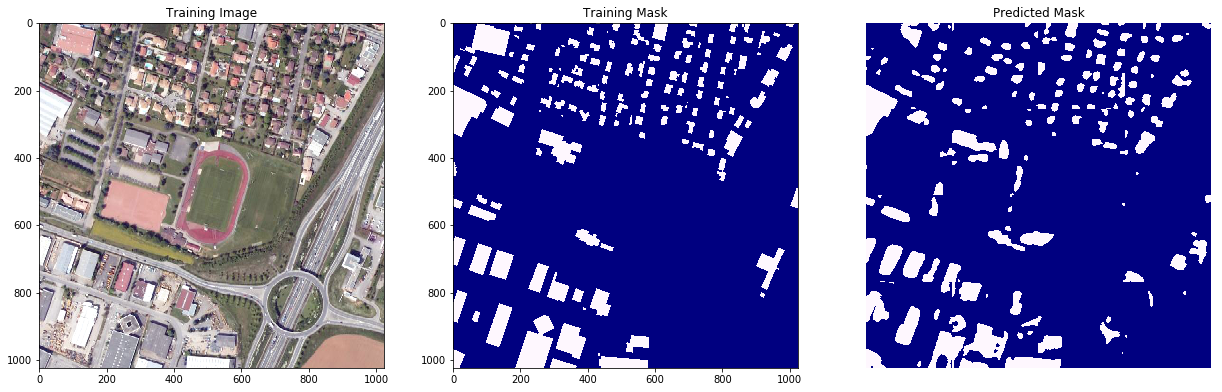

Lyon_1_0


In [25]:
model = get_unet_5()
model.load_weights('0unet5_c1.hdf5')
img_id = Image_ID[7]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


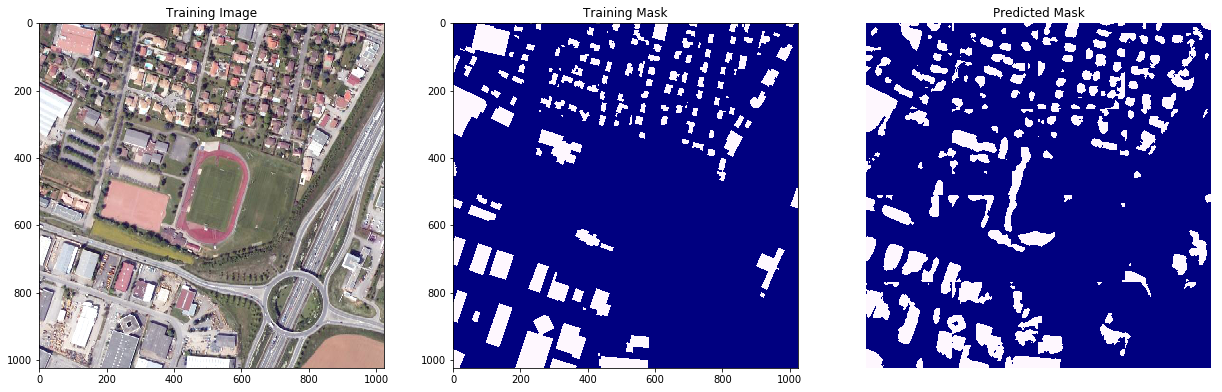

In [12]:
select_img_ids = random.sample(Image_ID, img_last)

ValueError: Sample larger than population or is negative

In [13]:
Image_ID

[]